test 2D optimisation with multi-task initialisation data

use branch `multi-task` to run this notebook!

In [1]:
import numpy as np
from boss.bo.bo_main import BOMain

In [2]:
import matplotlib.pyplot as plt

In [3]:
seed=123
init='random' # 'sobol' or 'random'

utilities:

In [4]:
import GPy

In [5]:
def load_model(filename):

    # load saved data
    saved=np.load(filename)
    dim=saved['X'].shape[1]

    # create kernel
    k=GPy.kern.StdPeriodic(input_dim=dim,ARD1=True,ARD2=True)

    # create mean function
    mf=GPy.mappings.Constant(dim,1)

    # create model
    m=GPy.models.GPRegression(saved['X'],saved['Y'],kernel=k,mean_function=mf)

    # set model params
    m[:]=saved['params']
    m.fix()
    m.parameters_changed()

    return m

optimisation task:

In [6]:
def f_0(x):
    return unknown_model_0.predict(np.atleast_2d(x))[0]

def f_1(x):
    return unknown_model_1.predict(np.atleast_2d(x))[0]

In [7]:
unknown_model_0=load_model('../models/model_2D_E0.npz')
unknown_model_1=load_model('../models/model_2D_E1.npz')
bounds=[[-50.0, 310.0]]*2

plot:

In [8]:
xp = np.linspace(-50, 310, 361)
levels = 25

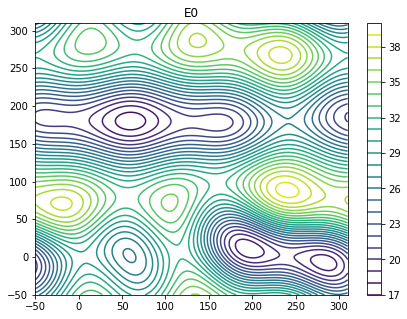

In [9]:
x1, x2 = np.meshgrid(xp,xp) 
yp = f_0(np.column_stack((x1.ravel(),x2.ravel())))
plt.figure(figsize=(7,5))
cset = plt.contour(xp, xp, yp.reshape(len(xp),len(xp)), levels=levels)
plt.colorbar(cset)
plt.title('E0');

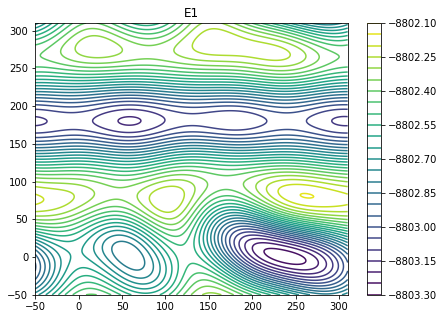

In [10]:
yp = f_1(np.column_stack((x1.ravel(),x2.ravel())))
plt.figure(figsize=(7,5))
cset = plt.contour(xp, xp, yp.reshape(len(xp),len(xp)), levels=levels)
plt.colorbar(cset)
plt.title('E1');

## baseline optimisation

In [11]:
bo_1 = BOMain(
    f_1, 
    bounds,
    yrange=[0, 1],
    kernel='stdp',
    inittype=init,
    initpts=5,
    iterpts=20,
    seed=seed
)

In [12]:
%time res_1 = bo_1.run()

CPU times: user 7.11 s, sys: 276 ms, total: 7.38 s
Wall time: 6.57 s


best observed value:

In [13]:
[res_1.xbest, res_1.ybest]

[array([243.62558475,  12.32353824]), -8803.208193525152]

estimated minimum and predicted minimum value:

In [14]:
[res_1.xmin, res_1.fmin]

[array([252.64215351,   0.40710484]), -8803.274395909277]

evaluate estimated minimum:

In [15]:
f_1(res_1.xmin)

array([[-8803.26313553]])

plot:

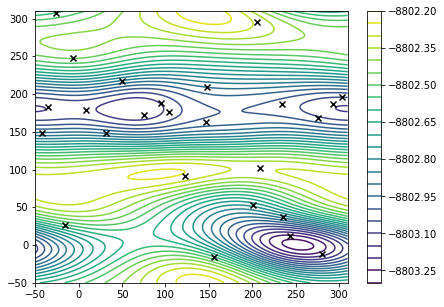

In [16]:
yp = bo_1.model.predict(np.column_stack((x1.ravel(),x2.ravel())))[0]
plt.figure(figsize=(7,5))
cset = plt.contour(xp, xp, yp.reshape(len(xp),len(xp)), levels=levels)
plt.colorbar(cset)
plt.scatter(bo_1.model.X[:,0],bo_1.model.X[:,1], marker='x', color='k', zorder=10);

## optimisation with multi-task initialisation data

In [17]:
bo_2 = BOMain(
    [f_1, f_0], 
    bounds,
    num_tasks=2,
    kernel='stdp',
    inittype=init,
    initpts=[5, 50],
    iterpts=20,
    seed=seed
)

note: scale normalisation is recommended with multi-task models

In [18]:
bo_2.settings['ynorm']

True

In [19]:
%time res_2 = bo_2.run()

CPU times: user 19.5 s, sys: 1.26 s, total: 20.7 s
Wall time: 14.9 s


In [20]:
[res_2.xbest, res_2.ybest]

[array([235.16863335,   1.19272308]), -8803.276926366987]

In [21]:
[res_2.xmin, res_2.fmin]

[array([236.22272271,   0.93587746]), -8803.2769673434]

evaluate estimated minimum:

In [22]:
f_1(res_2.xmin)

array([[-8803.27706482]])

plot:

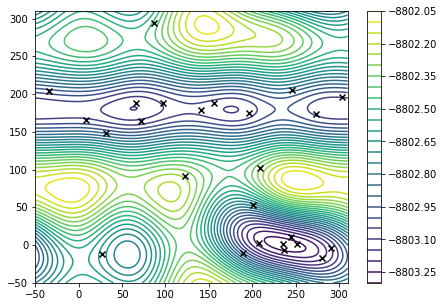

In [23]:
yp = bo_2.model.predict(np.column_stack((x1.ravel(),x2.ravel())))[0]
plt.figure(figsize=(7,5))
cset = plt.contour(xp, xp, yp.reshape(len(xp),len(xp)), levels=levels)
plt.colorbar(cset)
plt.scatter(bo_2.model.X[:,0], bo_2.model.X[:,1], marker='x', color='k', zorder=10);

support task:

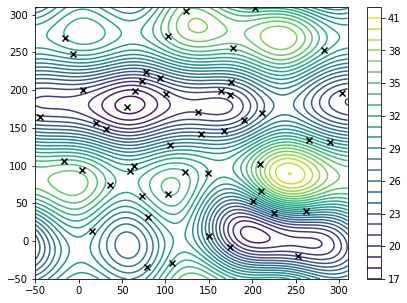

In [24]:
yp = bo_2.model.predict(np.column_stack((x1.ravel(),x2.ravel())), index=1)[0]
plt.figure(figsize=(7,5))
cset = plt.contour(xp, xp, yp.reshape(len(xp),len(xp)), levels=levels)
plt.colorbar(cset)
plt.scatter(bo_2.model.get_X(index=1)[:,0],bo_2.model.get_X(index=1)[:,1], marker='x', color='k', zorder=10);

note: these two are the same

In [25]:
bo_2.model.get_X(index=0).shape

(25, 2)

In [26]:
bo_2.model.X.shape

(25, 2)

In [27]:
np.all(bo_2.model.X == bo_2.model.get_X(index=0))

True

estimated variances and covariance between tasks:

In [28]:
bo_2.model.get_task_covariance()

array([[ 0.30633609,  4.70322163],
       [ 4.70322163, 86.32015759]])

see baseline and multi-task model params:

In [29]:
bo_1.model.get_all_params()

{'noise': 1e-12,
 'variance': 0.11869956948409996,
 'lengthscales': [0.8351868015429791, 0.323572789862551],
 'periods': [360.0, 360.0]}

In [30]:
bo_2.model.get_all_params()

{'noise': [1e-12, 1e-12],
 'lengthscales': [0.6182162838983282, 0.6814999279478109],
 'periods': [360.0, 360.0],
 'kappa': array([0.0230124 , 0.02225964]),
 'W': array([[0.52445491],
        [0.46460015]])}

the new parameters in the multi-task model are needed to model the above covariance matrix.

note that variance in the baseline model is associated with a gamma prior:

In [31]:
bo_1.kernel.kern.variance

GP_regression.mul.kern.variance:
Param([0.11869957])

we can add similar priors to the new parameters with keywords:

- `W_prior`
- `W_priorar`
- `kappa_prior`
- `kappa_priorpar`

In [32]:
W_prior='gaussian'
W_mean = 0.5
W_std = 0.2
kappa_prior ='gamma'
kappa_shape = 1
kappa_rate = 8

In [33]:
bo_3 = BOMain(
    [f_1, f_0], 
    bounds,
    num_tasks=2,
    kernel='stdp',
    inittype=init,
    initpts=[5, 50],
    iterpts=20,
    seed=seed,
    W_prior=W_prior,
    W_priorpar=[W_mean, W_std],
    kappa_prior=kappa_prior,
    kappa_priorpar=[kappa_shape, kappa_rate],
)

see kernel:

In [34]:
bo_3.kernel

In [35]:
bo_3.kernel.B.W

ICM0.B.W:
Param([[0.],
       [0.]])

In [36]:
bo_3.kernel.B.kappa

ICM0.B.kappa:
Param([0.5, 0.5])

run optimisation:

In [37]:
%time res_3 = bo_3.run()

CPU times: user 20.4 s, sys: 1.56 s, total: 22 s
Wall time: 14.8 s


In [38]:
[res_3.xbest, res_3.ybest]

[array([238.08819024,  -0.91663049]), -8803.27621601175]

In [39]:
[res_3.xmin, res_3.fmin]

[array([241.71528693,  -0.80101916]), -8803.27724534104]

evaluate estimated minimum:

In [40]:
f_1(res_3.xmin)

array([[-8803.27622782]])

plot:

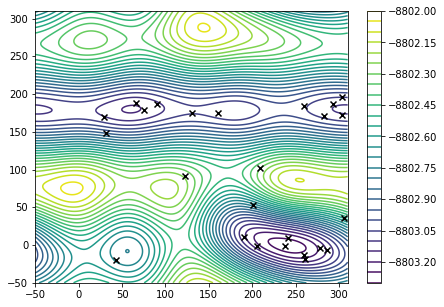

In [41]:
yp = bo_3.model.predict(np.column_stack((x1.ravel(),x2.ravel())))[0]
plt.figure(figsize=(7,5))
cset = plt.contour(xp, xp, yp.reshape(len(xp),len(xp)), levels=levels)
plt.colorbar(cset)
plt.scatter(bo_3.model.X[:,0],bo_3.model.X[:,1], marker='x', color='k', zorder=10);

see model params:

In [42]:
bo_3.model.get_all_params()

{'noise': [1e-12, 1e-12],
 'lengthscales': [0.6443430779215549, 0.7021618035779912],
 'periods': [360.0, 360.0],
 'kappa': array([0.03388975, 0.02918262]),
 'W': array([[0.53835828],
        [0.49702794]])}

prior distributions were studied in sten 2021 http://urn.fi/URN:NBN:fi:aalto-202101311714

recommended setup:

In [43]:
base_rate = 2/0.5**2

In [44]:
W_prior='gaussian'
W_mean = 0.9 * np.sqrt(2 / base_rate)
W_std = 0.5 / np.sqrt(base_rate)

In [45]:
bo_4 = BOMain(
    [f_1, f_0], 
    bounds,
    num_tasks=2,
    kernel='stdp',
    inittype=init,
    initpts=[5, 50],
    iterpts=20,
    seed=seed,
    W_prior=W_prior,
    W_priorpar=[W_mean, W_std],
)

In [46]:
%time res_4 = bo_4.run()

CPU times: user 27.5 s, sys: 2.14 s, total: 29.6 s
Wall time: 22 s


In [47]:
[res_4.xbest, res_4.ybest]

[array([237.83315046,   0.52752643]), -8803.277098912478]

In [48]:
[res_4.xmin, res_4.fmin]

[array([238.27382475,   0.45615916]), -8803.27710550343]

evaluate estimated minimum:

In [49]:
f_1(res_4.xmin)

array([[-8803.27707445]])

plot:

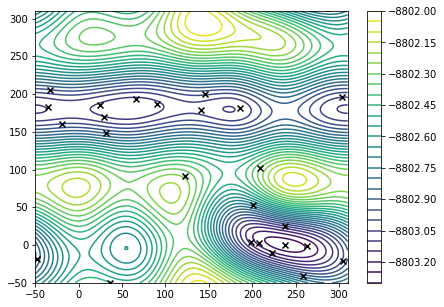

In [50]:
yp = bo_4.model.predict(np.column_stack((x1.ravel(),x2.ravel())))[0]
plt.figure(figsize=(7,5))
cset = plt.contour(xp, xp, yp.reshape(len(xp),len(xp)), levels=levels)
plt.colorbar(cset)
plt.scatter(bo_4.model.X[:,0],bo_4.model.X[:,1], marker='x', color='k', zorder=10);

see model params:

In [51]:
bo_4.model.get_all_params()

{'noise': [1e-12, 1e-12],
 'lengthscales': [0.6128379375156244, 0.672174202984808],
 'periods': [360.0, 360.0],
 'kappa': array([4.39096442e-02, 1.32899961e-07]),
 'W': array([[0.49519589],
        [0.46950383]])}